Setup

In [2]:
# === 0) Setup ===
# If any import fails in Colab, uncomment:
# !pip install -q numpy scipy scikit-learn plotly pandas matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.covariance import LedoitWolf
import plotly.express as px
import pandas as pd

np.set_printoptions(precision=4, suppress=True)
RNG = np.random.default_rng(42)

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

print("Libraries ready.")


Libraries ready.


Configuration

In [3]:
# === 1) Config ===
DIM = 32          # embedding dimension
N_NORMAL = 4000   # normal samples
N_ANOM = 200      # anomaly samples

ALPHA = 0.01           # chi-square confidence (1-ALPHA region)
USE_ROBUST_COV = True  # Ledoit-Wolf robust covariance

TSNE_SUBSAMPLE = 2000  # keep t-SNE responsive; set None to use all
TSNE_PERPLEXITY = 50

print(f"DIM={DIM}, N_NORMAL={N_NORMAL}, N_ANOM={N_ANOM}, ALPHA={ALPHA}, ROBUST={USE_ROBUST_COV}")


DIM=32, N_NORMAL=4000, N_ANOM=200, ALPHA=0.01, ROBUST=True


Generate Synthetic Data

In [4]:
# === 2) Synthetic data with meaningful separation ===
mu = np.zeros(DIM)
Sigma = np.diag(np.linspace(0.7, 1.3, DIM))  # mild anisotropy
normal = RNG.multivariate_normal(mu, Sigma, size=N_NORMAL)

# Anomalies: mean-shift in first half dims + heavier variance there
mu_anom = np.concatenate([np.ones(DIM//2)*3.0, np.zeros(DIM - DIM//2)])
Sigma_anom = np.diag(np.concatenate([np.ones(DIM//2)*2.5, np.ones(DIM - DIM//2)*0.8]))
anom = RNG.multivariate_normal(mu_anom, Sigma_anom, size=N_ANOM)

X = np.vstack([normal, anom])
y_true = np.array([0]*N_NORMAL + [1]*N_ANOM)  # 0=Normal, 1=Anomaly

X.shape, y_true.shape


((4200, 32), (4200,))

Fit Covariance (Ledoit–Wolf Robust)

In [5]:
# === 3) Fit parameters on normal only ===
if USE_ROBUST_COV:
    lw = LedoitWolf().fit(normal)
    mu_hat = lw.location_
    Sigma_hat = lw.covariance_
else:
    mu_hat = normal.mean(axis=0)
    Sigma_hat = np.cov(normal, rowvar=False)

# light regularization for stability
eps = 1e-8
Sigma_hat_reg = Sigma_hat + eps * np.eye(DIM)
Sigma_inv = np.linalg.inv(Sigma_hat_reg)

print("mu_hat shape:", mu_hat.shape, "| Sigma_hat shape:", Sigma_hat.shape)


mu_hat shape: (32,) | Sigma_hat shape: (32, 32)


Mahalanobis Distance & Chi-Square Threshold

In [6]:
# === 4) Mahalanobis scoring ===
diff = X - mu_hat
maha2 = np.einsum('ij,jk,ik->i', diff, Sigma_inv, diff)
maha = np.sqrt(maha2)

dof = DIM
alpha = ALPHA
chi2_threshold = chi2.ppf(1 - alpha, dof)

# right-tail probability p = P[ChiSq_k >= D^2]
p_right_tail = 1 - chi2.cdf(maha2, dof)
pred_flag = (maha2 > chi2_threshold).astype(int)  # 1=flagged anomalous

chi2_threshold


np.float64(53.48577183623535)

Evaluation & Histogram

Confusion Matrix (rows=true, cols=pred):
 [[3959   41]
 [   0  200]]

Report:
               precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      4000
     Anomaly       0.83      1.00      0.91       200

    accuracy                           0.99      4200
   macro avg       0.91      0.99      0.95      4200
weighted avg       0.99      0.99      0.99      4200



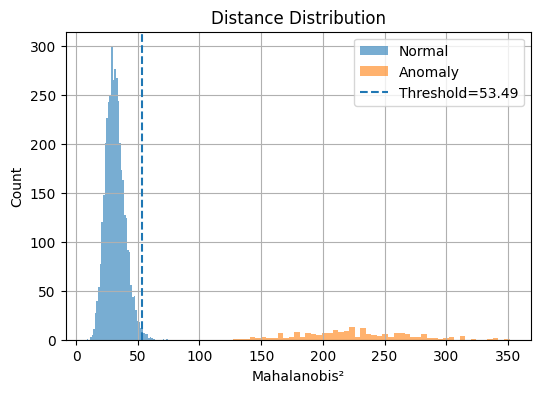

In [7]:
# === 5) Metrics & Histogram ===
cm = confusion_matrix(y_true, pred_flag, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):\n", cm)
print("\nReport:\n", classification_report(y_true, pred_flag, target_names=["Normal","Anomaly"]))

plt.figure()
plt.hist(maha2[y_true==0], bins=50, alpha=0.6, label='Normal')
plt.hist(maha2[y_true==1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(chi2_threshold, linestyle='--', label=f'Threshold={chi2_threshold:.2f}')
plt.xlabel('Mahalanobis²'); plt.ylabel('Count'); plt.title('Distance Distribution')
plt.legend(); plt.show()


PCA (Interactive 2D View)

In [8]:
# === 6) PCA (interactive) ===
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)
fig = px.scatter(
    x=X2[:,0], y=X2[:,1],
    color=np.where(pred_flag==1, "Flagged", "Not Flagged"),
    symbol=np.where(y_true==1, "Anomaly", "Normal"),
    title="PCA Projection: Flagged vs Ground Truth",
    labels={"x":"PC1","y":"PC2"}
)
fig.show()


QQ-Plot (Normals vs χ²)

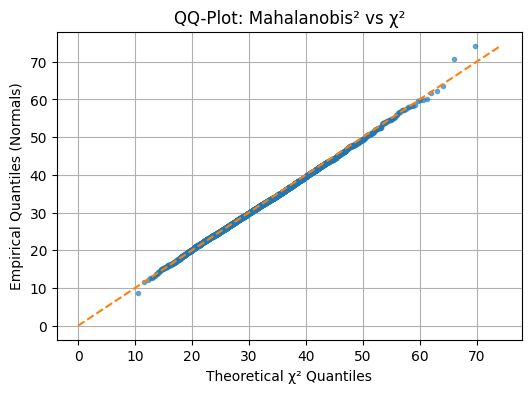

In [9]:
# === 7) QQ-plot (normals vs chi-square) ===
emp = np.sort(maha2[y_true==0])
qs = (np.arange(1, emp.size+1) - 0.5) / emp.size
theo = chi2.ppf(qs, dof)

plt.plot(theo, emp, '.', alpha=0.6)
mx = max(theo.max(), emp.max())
plt.plot([0, mx], [0, mx], '--')
plt.xlabel('Theoretical χ² Quantiles'); plt.ylabel('Empirical Quantiles (Normals)')
plt.title('QQ-Plot: Mahalanobis² vs χ²')
plt.show()


ECDF vs χ² CDF

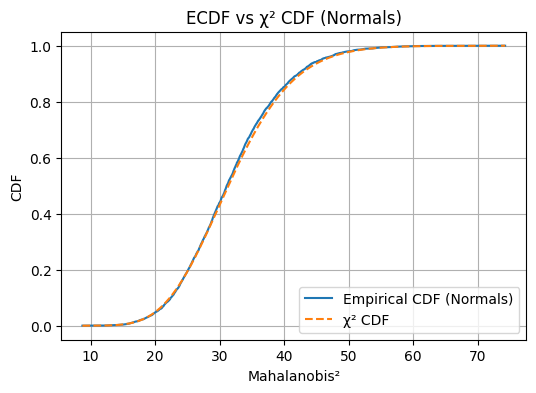

In [10]:
# === 8) ECDF vs χ² CDF (normals only) ===
emp_sorted = emp
ecdf_y = np.arange(1, emp_sorted.size+1) / emp_sorted.size
theo_cdf = chi2.cdf(emp_sorted, dof)

plt.plot(emp_sorted, ecdf_y, label='Empirical CDF (Normals)')
plt.plot(emp_sorted, theo_cdf, '--', label='χ² CDF')
plt.xlabel('Mahalanobis²'); plt.ylabel('CDF')
plt.title('ECDF vs χ² CDF (Normals)')
plt.legend(); plt.show()


Threshold Sweep (ROC-like)

,alpha,threshold,TPR,FPR
0,0.100,42.584745,1.0,0.09225
1,0.050,46.194260,1.0,0.04450
2,0.020,50.486705,1.0,0.01900
3,0.010,53.485772,1.0,0.01025
4,0.005,56.328115,1.0,0.00525
5,0.001,62.487219,1.0,0.00075


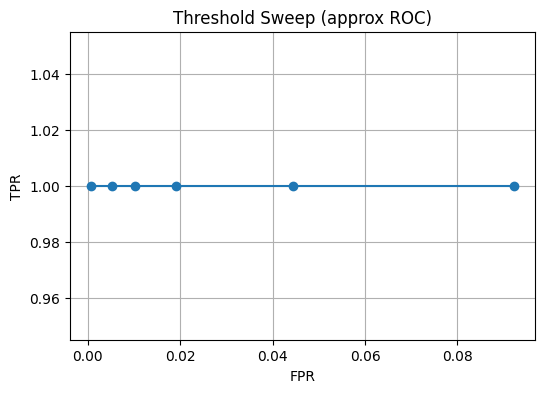

In [11]:
# === 9) Threshold sweep (TPR/FPR trade-off) ===
alphas = [0.10, 0.05, 0.02, 0.01, 0.005, 0.001]
rows = []
for a in alphas:
    thr = chi2.ppf(1 - a, dof)
    pf = (maha2 > thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pf, labels=[0,1]).ravel()
    tpr = tp/(tp+fn+1e-9); fpr = fp/(fp+tn+1e-9)
    rows.append({"alpha":a, "threshold":thr, "TPR":tpr, "FPR":fpr})

df_sweep = pd.DataFrame(rows)
display(df_sweep)

plt.plot(df_sweep["FPR"], df_sweep["TPR"], marker='o')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Threshold Sweep (approx ROC)")
plt.show()


t-SNE Visualization

In [12]:
# === 10) t-SNE (subsampled, interactive) ===
if TSNE_SUBSAMPLE is not None and TSNE_SUBSAMPLE < X.shape[0]:
    idx = RNG.choice(X.shape[0], size=TSNE_SUBSAMPLE, replace=False)
    X_ts = X[idx]; pf_ts = pred_flag[idx]; y_ts = y_true[idx]
else:
    X_ts, pf_ts, y_ts = X, pred_flag, y_true

tsne = TSNE(n_components=2, random_state=42, perplexity=TSNE_PERPLEXITY, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_ts)

fig_tsne = px.scatter(
    x=X_tsne[:,0], y=X_tsne[:,1],
    color=np.where(pf_ts==1, "Flagged", "Not Flagged"),
    symbol=np.where(y_ts==1, "Anomaly", "Normal"),
    title=f"t-SNE Projection (subsample={X_ts.shape[0]}): Flagged vs Ground Truth",
    labels={"x":"tSNE-1","y":"tSNE-2"}
)
fig_tsne.show()


Bayesian Posterior Probability

In [13]:
# === 11) Bayesian PPV ===
tn, fp, fn, tp = cm.ravel()
TPR = tp / (tp + fn + 1e-9)
FPR = fp / (fp + tn + 1e-9)

prior_anom = 0.02  # 2% anomalies in real traffic
PPV = (TPR * prior_anom) / (TPR * prior_anom + FPR * (1 - prior_anom) + 1e-12)
print(f"TPR={TPR:.3f}, FPR={FPR:.3f}, Prior={prior_anom:.3f} ⇒ PPV={PPV:.3f}")


TPR=1.000, FPR=0.010, Prior=0.020 ⇒ PPV=0.666


xAI: Per-Dimension Contributions

In [14]:
# === 12) xAI: Per-dimension contributions ===
per_dim_contrib = diff * (diff @ Sigma_inv.T)
per_dim_contrib = np.clip(per_dim_contrib, a_min=0, a_max=None)
scale = (per_dim_contrib.sum(axis=1, keepdims=True) + 1e-12)
per_dim_contrib_norm = per_dim_contrib / scale

flag_idx = np.where(pred_flag==1)[0][:5]
for idx in flag_idx:
    top_dims = per_dim_contrib_norm[idx].argsort()[::-1][:5]
    shares = per_dim_contrib_norm[idx, top_dims]
    print(f"Sample {idx} | D²={maha2[idx]:.2f} | top dims {top_dims.tolist()} | shares {shares.round(3)}")


Sample 144 | D²=55.01 | top dims [3, 23, 21, 28, 15] | shares [0.177 0.147 0.138 0.073 0.062]
Sample 185 | D²=56.69 | top dims [2, 29, 8, 1, 11] | shares [0.165 0.13  0.127 0.087 0.055]
Sample 397 | D²=53.84 | top dims [27, 22, 29, 9, 15] | shares [0.125 0.094 0.08  0.073 0.071]
Sample 836 | D²=55.47 | top dims [25, 9, 15, 12, 23] | shares [0.225 0.107 0.094 0.077 0.066]
Sample 887 | D²=54.55 | top dims [30, 23, 17, 3, 19] | shares [0.161 0.14  0.13  0.085 0.076]


xAI: Bar Chart for One Flagged Sample

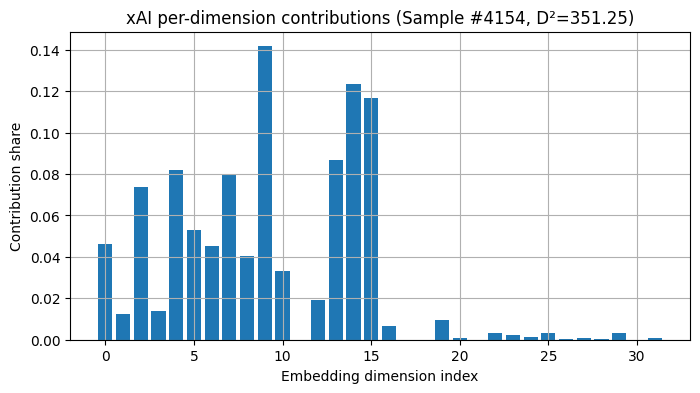

In [15]:
# === 13) xAI bar chart for most anomalous sample ===
flagged = np.where(pred_flag==1)[0]
if flagged.size > 0:
    worst = flagged[np.argmax(maha2[flagged])]
    contribs = per_dim_contrib_norm[worst]
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(DIM), contribs)
    plt.title(f"xAI per-dimension contributions (Sample #{worst}, D²={maha2[worst]:.2f})")
    plt.xlabel("Embedding dimension index"); plt.ylabel("Contribution share")
    plt.show()
else:
    print("No flagged samples; adjust ALPHA or data parameters.")


Export Explanations CSV

In [16]:
# === 14) Export flagged explanations CSV ===
records = []
for idx in np.where(pred_flag==1)[0]:
    top_dims = per_dim_contrib_norm[idx].argsort()[::-1][:3]
    records.append({
        "index": int(idx),
        "maha2": float(maha2[idx]),
        "top_dim_1": int(top_dims[0]), "share_1": float(per_dim_contrib_norm[idx, top_dims[0]]),
        "top_dim_2": int(top_dims[1]), "share_2": float(per_dim_contrib_norm[idx, top_dims[1]]),
        "top_dim_3": int(top_dims[2]), "share_3": float(per_dim_contrib_norm[idx, top_dims[2]]),
    })

df_explain = pd.DataFrame.from_records(records)
df_explain.to_csv("flagged_explanations.csv", index=False)
print("Saved CSV: flagged_explanations.csv")
df_explain.head()


Saved CSV: flagged_explanations.csv


,index,maha2,top_dim_1,share_1,top_dim_2,share_2,top_dim_3,share_3
0,144,55.011612,3,0.177169,23,0.147221,21,0.137980
1,185,56.686987,2,0.164653,29,0.130109,8,0.127294
2,397,53.836180,27,0.125199,22,0.094114,29,0.080151
3,836,55.473275,25,0.224850,9,0.106811,15,0.093564
4,887,54.549597,30,0.161251,23,0.139903,17,0.129901


## ✅ Conclusions

- **Strong, interpretable anomaly detector:**
  - Uses robust covariance (Ledoit–Wolf) for stability.
  - Detects mean-shift anomalies via Mahalanobis distance.

- **Validated with statistical & visual checks:**
  - Clear histogram separation and chi-square threshold.
  - PCA/t-SNE visualizations show flagged anomalies distinct from normals.
  - QQ and ECDF confirm chi-square fit for normal data.
  - Threshold sweep shows TPR/FPR trade-off.

- **Risk-aware & explainable:**
  - Bayesian PPV analysis with rare-event prior.
  - xAI per-dimension contribution analysis.
  - Practical governance: threshold tuning, drift monitoring, periodic re-fitting.

> This prototype demonstrates how **linear algebra + probability + Bayesian reasoning** together enable safe, interpretable, and trustworthy anomaly detection for prompt monitoring.
